In [1]:
import calitp
from calitp.tables import tbl
from calitp import get_engine
from siuba import *

import pandas as pd
import numpy as np
import geopandas as gpd
from plotnine import *

In [2]:
#!pip install plotnine

Querying `mst_ridership` for `MST`, turning it into a pandas DataFrame using collect()

In [3]:
df = (tbl.views.mst_ridership()
    >> filter(_.participant_id =='mst')
    >> collect()
    )

Create new column `rel_to_nominal`, add values for the relation to 'nominal_amount`

In [4]:
df = (df
     >> mutate(
         rel_to_nominal = case_when({
             _.charge_amount < _.nominal_amount: "paid_less",
             _.charge_amount == _.nominal_amount: "paid_the_same",
             _.charge_amount > _.nominal_amount: "paid_more"
         }),
         # alternative way if there are only two cases
         # something = if_else(_.charge_amount < _.nominal_amount, "less", "other")
     )
)

Counting the relations to nominal

In [5]:
(df
    >> count(_.rel_to_nominal)
)

,rel_to_nominal,n
0,paid_less,202
1,paid_the_same,33155


Counting relations to nominal by charge type

In [6]:
(df
    >> count(_.charge_type, _.rel_to_nominal)
)

,charge_type,rel_to_nominal,n
0,complete_variable_fare,paid_less,202
1,complete_variable_fare,paid_the_same,28270
2,flat_fare,paid_the_same,4885


Counting relation to nominal by charge amont and nominal amount

In [7]:
(df
    >> count(_.rel_to_nominal, _.charge_amount, _.nominal_amount)
)

,rel_to_nominal,charge_amount,nominal_amount,n
0,paid_less,0.0,1.5,34
1,paid_less,0.0,2.5,40
2,paid_less,0.0,3.5,2
3,paid_less,0.0,10.0,12
4,paid_less,0.5,1.5,6
5,paid_less,0.5,2.5,2
6,paid_less,1.0,1.5,16
7,paid_less,1.5,2.5,18
8,paid_less,1.5,3.5,10
9,paid_less,2.0,2.5,10


How many paid more than the nominal amount? (0)

In [8]:
(df
    >> filter(_.rel_to_nominal == "paid_more_than")
    >> summarize(n_fares = _.rel_to_nominal.count()
                )
)

,n_fares
0,0


How many paid less than the nominal amount?

In [9]:
(df
    >> filter(_.rel_to_nominal == "paid_less")
    >> summarize(n_fares = _.rel_to_nominal.count())
)

,n_fares
0,202


How many paid the same as the nominal amount?

In [10]:
(df
    >> filter(_.rel_to_nominal == "paid_the_same")
    >> summarize(n_fares = _.rel_to_nominal.count()
            )
)

,n_fares
0,33155


How many had a flat fare but paid less than the nominal amount?

In [11]:
(df
    >> filter(_.rel_to_nominal == "paid_less", _.charge_type == "flat_fare")
    >> summarize(n_fares = _.charge_type.count()
                )
)

,n_fares
0,0


How many paid $0

In [12]:
(df
    >> filter(_.charge_amount == 0.0)
    >> summarize(n_fares = _.charge_amount.count()
                )
)

,n_fares
0,252


How many paid less than the nominal amount, and paid $0

In [13]:
(df
    >> filter(_.rel_to_nominal == "paid_less", _.charge_amount == 0.0)
    >> summarize(n_fares = _.charge_amount.count()
                )
)

,n_fares
0,88


How many paid the same as the nominal amount, and paid $0

In [14]:
(df
    >> filter(_.rel_to_nominal=="paid_the_same", _.nominal_amount==0.0, _.charge_amount==0.0)
    >> summarize(n_fares = _.charge_amount.count()
                )
)

,n_fares
0,164


How many paid $0, by charge type and the relation to the nominal amount

In [15]:
(df
    >> filter(_.charge_amount==0.0)
    >> count(_.charge_amount, _.charge_type, _.rel_to_nominal)
)

,charge_amount,charge_type,rel_to_nominal,n
0,0.0,complete_variable_fare,paid_less,88
1,0.0,complete_variable_fare,paid_the_same,164


How many paid less than the nominal amount, but paid more than $0

In [16]:
(df
    >> filter(_.rel_to_nominal=="paid_less", _.charge_amount!=0.0)
    >> summarize(n_fares = _.rel_to_nominal.count()
                )
)

,n_fares
0,114


Scatterplot comparing nominal amount, charge amount, and charge type

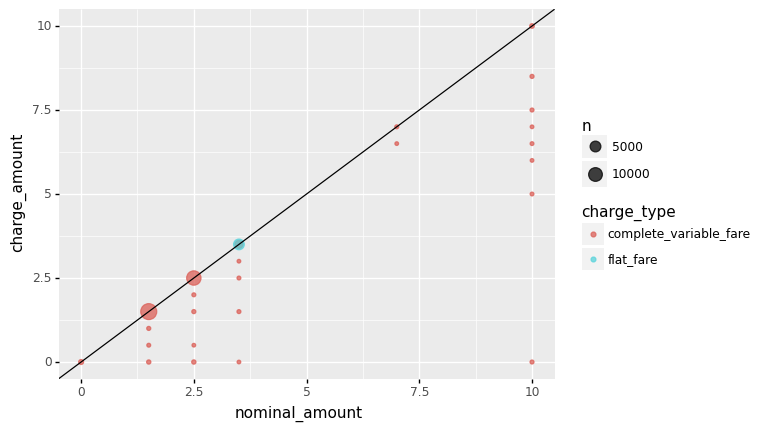

<ggplot: (8768571410863)>

In [17]:
(df
  >> count(_.charge_type, _.nominal_amount, _.charge_amount)
  >> ggplot(aes("nominal_amount", "charge_amount", size="n", color="charge_type"))
  + geom_point(alpha=.75)
  + geom_abline()
)

Fare Tables - Route Type

| Route Type | Regular Fare | Discount Fare |
| ----------- | ----------- | --- |
| Local | 1.50 | 0.75 |
| Primary | 2.50 | 1.25 |
| Regional | 3.50 | 1.75 |
| Commuter | 12.00 | 6.00 |

Fare Tables - Distance

| Distance | Regular Contactless Fare | 
| ----------- | ----------- | 
| Up to 2.7 miles | 1.50 | 
| Between 2.7 and 14 miles | 2.50 |
| 14 – 50 miles | 3.50 | 
| 50 – 77 miles | 7.00 |
| 77 miles or more | 10.00 |
